In [40]:
from typing import Tuple
import math

def linspace(start, stop, step=100):
    '''evenly spaced values from start to stop'''
    if step < 2:
        return start
    diff = (float(stop) - start)/(step - 1)
    return [diff * i + start for i in range(step)]

APPROX_ZERO = 1e-25

def safe_log10(operand, minval=APPROX_ZERO):
    '''safe base 10 log'''
    return math.log10(operand.clip(min=minval))

class CombFilter:
    '''comb filter'''
    def __init__(self, **kwargs):
        '''init'''
        self.gain = kwargs.get('gain', 1.0)
        self.order = kwargs.get('order', 0)
        self._counter = 0
        # state buffer can be omitted in application
        # it is used for clarity sake, but can be substituted
        # by waiting until N samples have been taken, and
        # recording s[-N] for later use in a single state variable
        self._states = [0]*(self.order+1)
        self._output = 0

    #pylint: disable=too-many-locals
    def evaluate_at_frequency(self, freq: float, sample_rate: float) -> Tuple:
        """
        evaluate the comb for a given frequency and sample rate

        :returns:   (abs(magnitude), phase angle)
        :rtype:     Tuple
        """
        # calculate constants, we can precompute sine and cosine terms
        # since we are evaluating for a single frequency
        omega = 2*math.pi * (freq/sample_rate)
        cos = math.cos(omega*self.order)
        sin = math.sin(omega*self.order)
        
        if self.gain == 0:
            magnitude = 1.0
            phase = 0
        else: 
            magnitude = abs(math.sqrt((1+self.gain*cos)**2 + (self.gain*sin)**2))
            phase = math.atan((self.gain*sin)/(1+self.gain*cos))
    
        return (magnitude, phase)

    def reset(self, initial_condition=None):
        '''reset network'''
        if initial_condition is None:
            initial_condition = 0
        self._states = [initial_condition]*(self.order+1)
        self._counter = 0

    def update(self, sample):
        '''update the comb with a new sample,
        not sure if this is the correct to handle intial samples'''
        # quick n dirty delay line
        last_value = self._states.pop(1)
        self._states.append(sample)
        self._counter += 1
        if self._counter >= self.order:
            self._counter = self.order
        self._output = sample - last_value*self.gain

    @property
    def output(self):
        '''get the output of the comb'''
        return self._output

class DF2TBiquad:
    """
    Direct-Form-2 Transposed Biquad
    """
    def __init__(self, **kwargs):
        '''init'''
        #pylint: disable=C0103
        # Gains                  G[0], G[1], G[2]
        self.A = kwargs.get('A', [1.0, 0.0, 0.0])
        self.B = kwargs.get('B', [1.0, 0.0, 0.0])

        self._states = [0.0]*3
        self._output = 0.0

    #pylint: disable=too-many-locals
    def evaluate_at_frequency(self, freq: float, sample_rate: float) -> Tuple:
        """
        evaluate the filter for a given frequency and sample rate

        :returns:   (abs(magnitude), phase angle)
        :rtype:     Tuple
        """
        # calculate constants, we can precompute sine and cosine terms
        # since we are evaluating for a single frequency
        omega = 2*math.pi * (freq/sample_rate)
        cos1 = math.cos(omega)
        cos2 = math.cos(2*omega)
        sin1 = math.sin(omega)
        sin2 = math.sin(2*omega)

        # calculate numerator and denominator terms, implied that j has been factored out
        # from y terms such that it can be squared later
        numx = self.B[0] + self.B[1]*cos1 + self.B[2]*cos2
        numy = self.B[1]*sin1 - self.B[2]*sin2
        demx = 1.0/self.A[0] - self.A[1]*cos1 - self.A[2]*cos2
        demy = self.A[1]*sin1 - self.A[2]*sin2
    
        # calculate magnitude
        numhz = math.sqrt(numx**2 + numy**2)
        demhz = math.sqrt(demx**2 + demy**2)
        magnitude = abs(numhz/demhz)

        # calculate phase angle
        safe_numx = APPROX_ZERO if numx == 0.0 else numx
        safe_numy = APPROX_ZERO if numy == 0.0 else numy
        safe_demx = APPROX_ZERO if demx == 0.0 else demx
        safe_demy = APPROX_ZERO if demy == 0.0 else demy
        phase = math.atan(safe_numy/safe_numx) - math.atan(safe_demy/safe_demx)

        return (magnitude, phase)

    def reset(self, initial_conditions=None):
        '''reset biquad'''
        if initial_conditions is None:
            self._states = [0.0]*3
        else:
            self._states = initial_conditions[0:3]

    def update(self, sample):
        '''update biquad with new sample'''
        # states are in reverse,
        # i.e.
        #   S[2] = a0 * (sample - a1*S[1] - a2*S[0])
        #   S[1] = z^-1
        #   S[0] = z^-2

        # push new sample in, pop old one out
        # 3mult, 2add
        # --> 3rd mult is so we can have a0
        self._states.append(
            self.A[0]*\
            (sample - self.A[1]*self._states[-1]) -\
            self.A[2]*self._states[-2]
        )
        self._states.pop(1)
        # 3mult, 2add
        self._output = \
            self.B[0]*self.states[-1] + \
            self.B[1]*self.states[-2] + \
            self.B[2]*self.states[-3]

    @property
    def output(self):
        '''get output'''
        return self._output

class SAKNetwork:
    """
    "Swiss-Army-Knife" filter structure
    """
    def __init__(self, **kwargs):
        '''init'''
        self.comb = CombFilter(
            gain=kwargs.get('C', 0),
            order=kwargs.get('N', 0)
        )
        self.biquad = DF2TBiquad(
            A=kwargs.get('A', None),
            B=kwargs.get('B', None)
        )
        self._output = 0.0

    def evaluate_at_frequency(self, freq: float, sample_rate: float) -> Tuple:
        """
        evaluate the filter for a given frequency and sample rate

        :returns:   (abs(magnitude), phase angle)
        :rtype:     Tuple
        """
        responses = [
            self.comb.evaluate_at_frequency(freq, sample_rate),
            self.biquad.evaluate_at_frequency(freq, sample_rate)
        ]

        # calculate magnitude
        magnitude = responses[0][0] * responses[1][0]
        # calculate phase angle
        phase = responses[0][1] + responses[1][1]

        return (magnitude, phase)

    def get_frequency_response(self, freq_range, sample_rate: float, **options) -> Tuple:
        """
        Gets the frequency response for a given range of frequencies

        :param      freq_range:   The frequency range
        :type       freq_range:   [start_freq, end_freq]
        :param      sample_rate:  The sample rate
        :type       sample_rate:  float
        :param      options:      The options
        :type       options:      dictionary

        :returns:   ([freq], [abs(magnitude)], [phase angle])
        :rtype:     Tuple
        """
        logy = options.get('logy', False)
        num_steps = options.get('num_steps', 1000)
        max_freq = freq_range[-1]
        if freq_range[-1] >= (sample_rate/2):
            max_freq = sample_rate / 2
        frequencies = linspace(freq_range[0], max_freq, num_steps)

        results = ([], [], [])
        for frequency in frequencies:
            if frequency == 0:
                continue
            magnitude, phase_angle = self.evaluate_at_frequency(frequency, sample_rate)
            magnitude = 20*math.log10(magnitude)
            results[0].append(frequency)
            results[1].append(magnitude)
            results[2].append(phase_angle)
        return results

    def update(self, sample):
        '''update network with new sample'''
        self.comb.update(sample)
        self.biquad.update(self.comb.output)

    def reset(self):
        '''reset the state variables to zero'''
        self.comb.reset()
        self.biquad.reset()


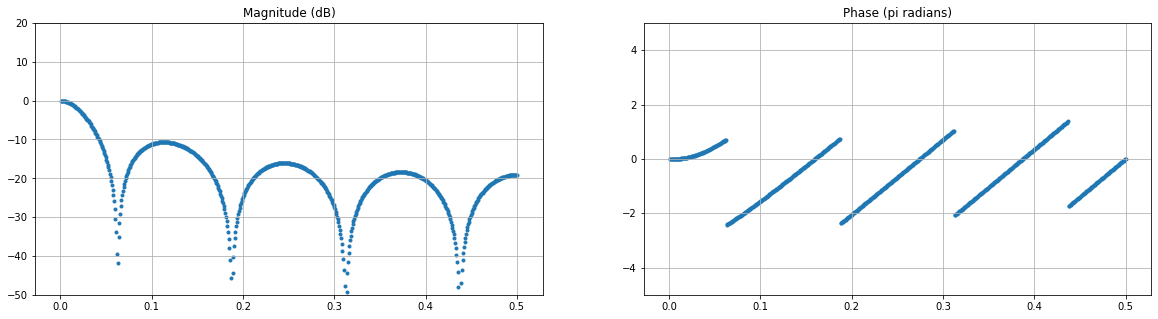

In [44]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]
plt.grid()
# moving averager from Table 1
# A0 set below unity to keep network stable
ma = SAKNetwork(
    A=[0.8, 1, 0], 
    B=[1/8, 0, 0],
    C=1,
    N=8,
)

response = ma.get_frequency_response(
    freq_range=[0, 1],
    sample_rate=1,
    num_steps=666,
    logy=True
)

# calculate again but with scipy
import scipy.signal as sig

plt.subplot(121, ylim=(-50, 20))
plt.grid()
plt.title('Magnitude (dB)')
plt.scatter(response[0], response[1], marker='.')
plt.subplot(122, ylim=(-5, 5))
plt.grid()
plt.title('Phase (pi radians)')
plt.scatter(response[0], response[2], marker='.')

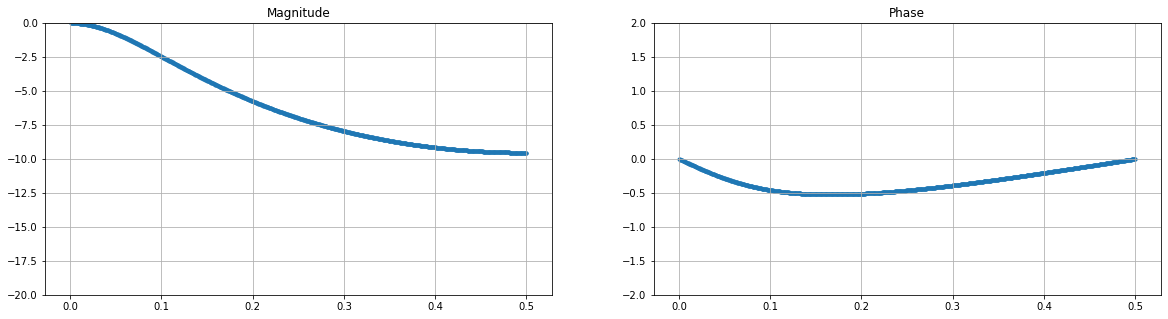

In [28]:
# integrator from Table 1
itg = SAKNetwork(
    A=[0.5, 1, 0],
    B=[1, 0, 0],
    C=0,
    N=1,
)

response = itg.get_frequency_response(
    freq_range=[0, 1],
    sample_rate=1,
    num_steps=1000
)
plt.subplot(121, ylim=(-20, 0))
plt.grid()
plt.title('Magnitude')
plt.scatter(response[0], response[1], marker='.')
plt.subplot(122, ylim=(-2, 2))
plt.grid()
plt.title('Phase')
plt.scatter(response[0], response[2], marker='.')

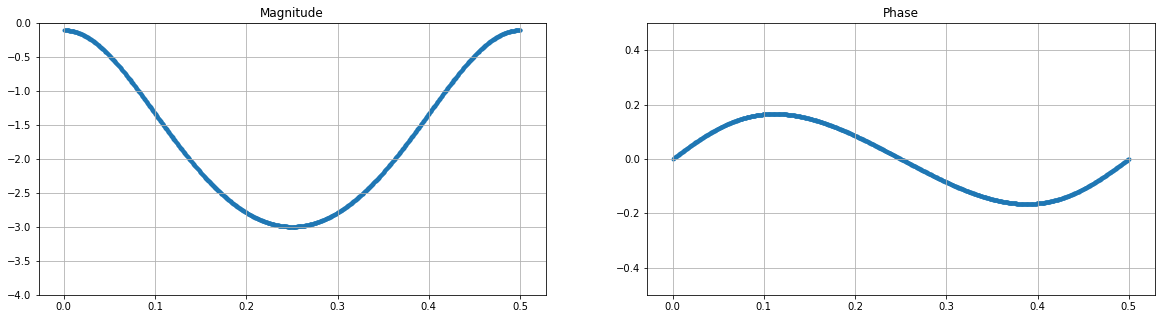

In [37]:
# audio comb from Table 2
itg = SAKNetwork(
    A=[0.825, 0, 0.2],
    B=[1, 0, 0],
    C=0,
    N=0,
)

response = itg.get_frequency_response(
    freq_range=[0, 1],
    sample_rate=1,
    num_steps=1000
)
plt.subplot(121, ylim=(-4, 0))
plt.grid()
plt.title('Magnitude')
plt.scatter(response[0], response[1], marker='.')
plt.subplot(122, ylim=(-.5, .5))
plt.grid()
plt.title('Phase')
plt.scatter(response[0], response[2], marker='.')